In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import mplhep as hep
from jetnet.datasets import JetNet
from model.refinement import GNN, FCN, NodeFCN, GNN2
from model.mpgan.model import MPNet
plt.style.use(hep.style.CMS)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [36]:
model = MPNet(30, 3, output_node_size=3)
# model = GNN()
# model = GNN2()
# model = FCN()
# model = NodeFCN()
model.load_state_dict(torch.load('refinement/models/MPNet_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/GNN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/FCN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/NodeFCN_refinement.pt'))
model.cuda();
count_parameters(model)

348131

In [37]:
np.random.seed(99)
def load_gluon_dataset(dataroot):
    particle_data, jet_data = JetNet.getData(jet_type=["g"], data_dir=dataroot)
    particle_data = particle_data[..., :-1] # toss mask dimension
    dataset_size = 4000
    np.random.shuffle(particle_data)
    particle_data = particle_data[:dataset_size]
    m = particle_data.mean(axis=1).reshape(-1, 1, 3)
    s = particle_data.std(axis=1).reshape(-1, 1, 3)
    return particle_data * s + m

In [38]:
samples = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/samples.pth')
# ref = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/ref.pth')
ref = load_gluon_dataset('/diffusionvol/data/')
samples = samples.numpy()
# ref = ref.numpy()

In [39]:
_samples = []
bs = 256
for i in range(0, len(samples), bs):
    _samples.append(model(torch.tensor(samples[i:i+bs]).cuda()))
_samples = torch.cat(_samples)
_samples.shape

torch.Size([4000, 30, 3])

In [40]:
samples = _samples.detach().cpu().numpy()

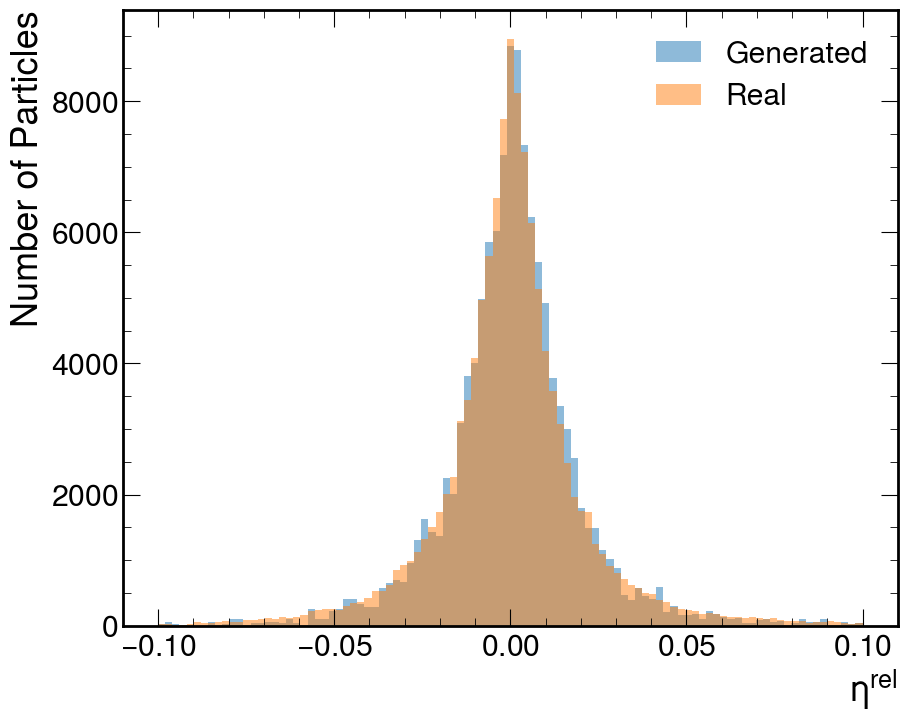

In [41]:
plt.figure(figsize=(10,8))
plt.hist(samples[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\eta^{rel}$")
plt.ylabel('Number of Particles')
plt.savefig('eta.png')
plt.show()

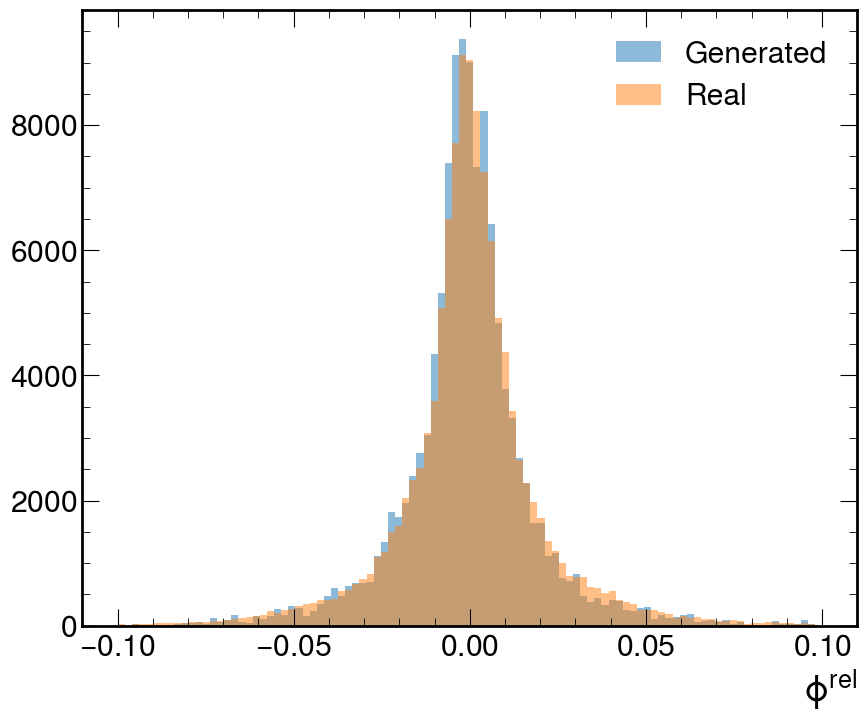

In [42]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\phi^{rel}$")
plt.savefig('phi.png')
plt.show()

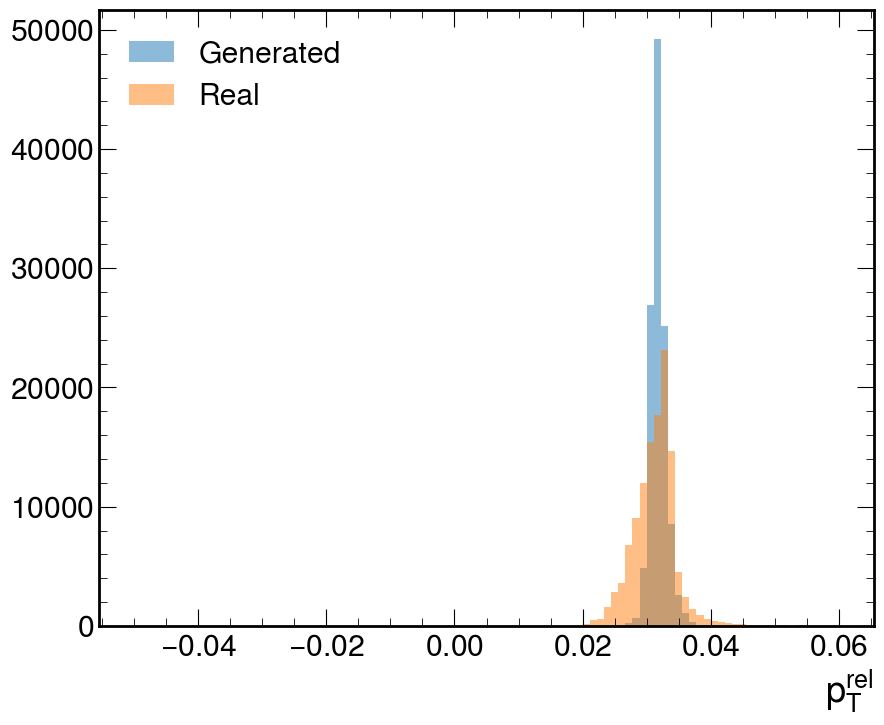

In [43]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$p_T^{rel}$")
plt.savefig('pt.png')
plt.show()

In [44]:
from jetnet import evaluation

In [45]:
samples_pt_pos = samples
samples_pt_pos[..., -1] = samples_pt_pos[..., -1].clip(min=0)

In [46]:
cov, mmd = evaluation.cov_mmd(samples_pt_pos, ref)

Calculating cov and mmd over 10 batches: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


In [47]:
print(f'COV: {cov}')
print(f'MMD: {mmd}')

COV: 0.395
MMD: 0.017674037444337216


In [48]:
w1efpm, w1efpstd = evaluation.w1efp(
    samples,
    ref,
    use_particle_masses=False,
    average_over_efps=True,
    return_std=True
)
print(w1efpm, w1efpstd)

1.2461914452056303e-07 7.944033264666173e-09


In [49]:
fpd = evaluation.fpnd(samples, jet_type='g')

Running ParticleNet: 100%|██████████| 250/250 [00:01<00:00, 145.34it/s]


In [50]:
fpd

136.37730724175447